In [68]:
import os
import numpy as np
import glob
from collections import defaultdict
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
from pyproj import Geod
import pickle

# Data Import

In [69]:
path = '/glade/work/stevenxu/CESM1'
all_files = glob.glob(os.path.join(path, "*.nc"))
print(all_files) 
datasets = {}
for file in all_files:
    varname = os.path.basename(file).split("_")[0]
    datasets[varname] = xr.open_dataset(file)

['/glade/work/stevenxu/CESM1/PREC_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/ROFF_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/SHF_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/MELT_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/EVAP_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/IOFF_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/PD_preindustrial_spinup.nc']


In [70]:
PREC = datasets["PREC"].isel(time=slice(-240,None))
ROFF = datasets["ROFF"].isel(time=slice(-240,None))
SHF  = datasets["SHF"].isel(time=slice(-240,None))
MELT = datasets["MELT"].isel(time=slice(-240,None))
EVAP = datasets["EVAP"].isel(time=slice(-240,None))
IOFF = datasets["IOFF"].isel(time=slice(-240,None))
PD   = datasets["PD"].isel(time=slice(-240,None))

In [71]:
MELT

<xarray.Dataset> Size: 12MB
Dimensions:      (time: 240, d2: 2, nlat: 116, nlon: 100)
Coordinates:
  * time         (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
    ULONG        (nlat, nlon) float64 93kB ...
    ULAT         (nlat, nlon) float64 93kB ...
    TLONG        (nlat, nlon) float64 93kB ...
    TLAT         (nlat, nlon) float64 93kB ...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound   (time, d2) object 4kB ...
    REGION_MASK  (nlat, nlon) float64 93kB ...
    UAREA        (nlat, nlon) float64 93kB ...
    TAREA        (nlat, nlon) float64 93kB ...
    MELT_F       (time, nlat, nlon) float32 11MB ...
Attributes: (12/13)
    title:           restart_spunup_v15
    history:         Thu Mar 27 17:21:35 2025: ncrcat -v MELT_F,TAREA,UAREA,R...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 58852 2014-04-04 21:28:27Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2022-07-29 at 12:56:18.1
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    9485645
    tavg_sum:        2678400.0
    tavg_sum_qflux:  2678400.0
    NCO:             netCDF Operators version 5.2.6 (Homepage = http://nco.sf...

In [72]:
prec = PREC['PREC_F']
roff = ROFF['ROFF_F']
melt = MELT['MELT_F']
evap = EVAP['EVAP_F']
ioff = IOFF['IOFF_F']

# Calculate freshwater flux
FWF = (roff + ioff + melt + prec + evap).rename('FWF')
FWF = FWF.assign_attrs({
    'long_name': 'Total Freshwater Flux',
    'units': 'kg/m^2/s',
    'components': 'ROFF_F + IOFF_F + MELT_F + PREC_F + EVAP_F'
})
FWF = ROFF.assign(FWF=FWF)
FWF = FWF.drop_vars('ROFF_F')

# convert density unit from g/cm^3 to kg/m^3
PD["PD"] = PD["PD"] * 1000.0
PD["PD"].attrs["units"] = "kg/m^3"


In [73]:
density_data = PD
hf_datasets = SHF
wf_datasets = FWF

In [74]:
wf_datasets

<xarray.Dataset> Size: 12MB
Dimensions:      (time: 240, d2: 2, nlat: 116, nlon: 100)
Coordinates:
  * time         (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
    ULONG        (nlat, nlon) float64 93kB ...
    ULAT         (nlat, nlon) float64 93kB ...
    TLONG        (nlat, nlon) float64 93kB ...
    TLAT         (nlat, nlon) float64 93kB ...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound   (time, d2) object 4kB ...
    REGION_MASK  (nlat, nlon) float64 93kB ...
    UAREA        (nlat, nlon) float64 93kB ...
    TAREA        (nlat, nlon) float64 93kB ...
    FWF          (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
Attributes: (12/13)
    title:           restart_spunup_v15
    history:         Thu Mar 27 17:21:35 2025: ncrcat -v ROFF_F,TAREA,UAREA,R...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 58852 2014-04-04 21:28:27Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2022-07-29 at 12:56:18.1
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    9485645
    tavg_sum:        2678400.0
    tavg_sum_qflux:  2678400.0
    NCO:             netCDF Operators version 5.2.6 (Homepage = http://nco.sf...

# Calculate F surf

- Overall mean alpha: 0.00019915005771352584
- Overall mean beta: 0.000746301819876489

In [75]:
def compute_fsurf(
				density_data, hf_datasets, wf_datasets,
				cp=3990.0, rho0=1027.0, rho_fw=1000.0, S0=35.0,
				last_n_months=None):

	HF = hf_datasets['SHF']  # W m^-2, 
	WF = wf_datasets['FWF']     # kg m^-2 s^-1, 
	area = wf_datasets["TAREA"]
	region_mask = hf_datasets["REGION_MASK"]

	rho = density_data['PD']
	alpha = 0.0001391022569339093
	beta = 0.0007600059551595953

	if last_n_months is not None:
		HF  = HF.isel(time=slice(-last_n_months, None))
		WF = WF.isel(time=slice(-last_n_months, None))

    # f_surf = -(alpha/cp) * f_heat  - (rho0/rho_fw) * beta * S0 * f_water
	fsurf = (alpha / cp) * HF  +  (rho0 / rho_fw) * beta * S0 * WF
	fsurf = fsurf.assign_attrs(
		long_name="Buoyancy-relevant surface forcing (Eq. 5)",
		description="(alpha/cp)*f_heat + (rho0/rho_fw)*beta*S0*f_water",
		units="",
		cp=cp, rho0=rho0, rho_fw=rho_fw, S0=S0
	)

	heat_comp = (alpha / cp) * HF
	fw_comp = (rho0 / rho_fw) * beta * S0 * WF

	return xr.Dataset(dict(fsurf=fsurf, rho=rho, heat_comp=heat_comp, fw_comp=fw_comp, area=area, region_mask=region_mask))

Fsurf_data = compute_fsurf(
	density_data = density_data,
	hf_datasets = hf_datasets,
	wf_datasets = wf_datasets,
	last_n_months=None
)

Fsurf_data
# Drop the z_t coordinate 
Fsurf_data = Fsurf_data.isel(z_t=0).drop_vars('z_t')
#Fsurf_data.isel(z_t=0)


# Calculating Fgen at single timepoint

### Create density class list
Take max and min in rho values, and slice with interval 0.01

In [76]:
ds = Fsurf_data
da = ds['rho'].isel(time=0)
rho_min = float(da.min())
rho_max = float(da.max())

In [77]:
step_size = 0.05
rho_classes = np.arange(rho_min - step_size, rho_max + 2* step_size, step_size)

### Dataset for area at each grid cell

In [78]:
area = Fsurf_data["area"]/1e4

### Integration

Group by density intervals and adding up the area-weighted fsurf

Filtering by Lat and region

In [79]:
# create a mask to filter by latitude and region mask
lat    = Fsurf_data["TLAT"].stack(points=("nlat","nlon"))
region = Fsurf_data["region_mask"].stack(points=("nlat","nlon"))

region_values = [6.0, 8.0, 9.0, 10.0]
mask = (lat > 45) & region.isin(region_values)

# Keep point labels that pass both
keep_pts = mask.where(mask, drop=True).coords["points"]

# stack or flatten data into 1d array
fsurf = Fsurf_data["fsurf"].stack(points=("nlat","nlon")).sel(points=keep_pts)
rho   = Fsurf_data["rho"].stack(points=("nlat","nlon")).sel(points=keep_pts)
area1 = area.stack(points=("nlat","nlon")).sel(points=keep_pts)

# revert to origional shape
weighted_fsurf = (fsurf * area1).unstack("points")
rho = rho.unstack("points")


In [86]:
keep_pts

<xarray.DataArray 'points' (points: 1916)> Size: 15kB
array([(80, 7), (80, 8), (80, 9), ..., (114, 84), (114, 86), (114, 87)],
      dtype=object)
Coordinates:
    ULONG    (points) float64 15kB 348.8 352.2 355.6 359.1 ... 305.3 306.3 306.9
    ULAT     (points) float64 15kB 45.99 46.25 46.53 46.83 ... 71.98 71.24 70.87
    TLONG    (points) float64 15kB 347.2 350.6 354.1 357.5 ... 304.4 305.4 306.0
    TLAT     (points) float64 15kB 45.06 45.29 45.55 45.83 ... 72.09 71.33 70.94
  * points   (points) object 15kB MultiIndex
  * nlat     (points) int64 15kB 80 80 80 80 80 81 ... 114 114 114 114 114 114
  * nlon     (points) int64 15kB 7 8 9 10 92 0 1 2 3 ... 20 80 81 82 83 84 86 87

Integration

In [81]:
# Summing up by dentisy interval
Fgen_org = weighted_fsurf.groupby_bins(rho, bins=rho_classes, right=False).sum(dim=("nlat","nlon")) / step_size /1e6

# adding centered coordinate for density intervals
rho_centers = (rho_classes[:-1] + rho_classes[1:]) / 2

# organizing
Fgen = Fgen_org.assign_coords(rho_center=("rho_bins", rho_centers))
Fgen = Fgen.rename(rho_bins="rho_intervals")
Fgen = Fgen.rename('Fgen')
Fgen

<xarray.DataArray 'Fgen' (rho_intervals: 517, time: 240)> Size: 993kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time           (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
  * rho_intervals  (rho_intervals) int64 4kB 0 1 2 3 4 5 ... 512 513 514 515 516
    rho_center     (rho_intervals) float64 4kB 1.004e+03 1.004e+03 ... 1.029e+03

In [82]:
save_path = f"/glade/work/stevenxu/AMOC_models/CESM1_Fgen.pkl"
with open(save_path, "wb") as f:
    pickle.dump(Fgen, f)

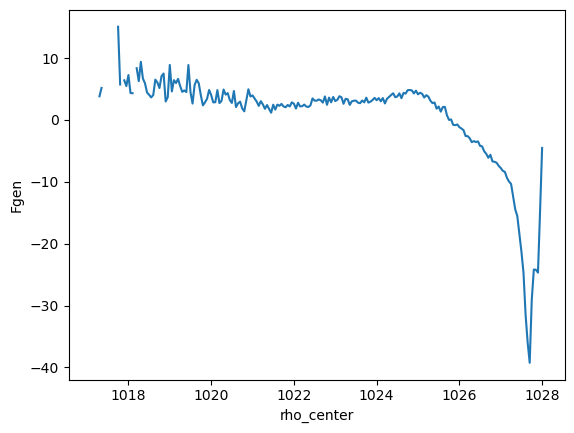

In [83]:
Fgen.mean(dim ='time').plot(x = 'rho_center')
